# DATA 620 ~ Project 2
***
### David Moste - Euclid Zhang - Samuel Reeves
***

What are the most important food products in this Amazon review dataset?

https://youtu.be/onfJ9zBbzhY

In [1]:
import requests
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import numpy as np
import regex
import matplotlib.pyplot as plt
import dill

### Data Description

Data Source: https://snap.stanford.edu/data/web-FineFoods.html

>This dataset is composed of roughly 500k reviews of foods from Amazon. We will build a 2-mode network consisting of the food products and customers who wrote the reviews.

### Data Preparation

First, we load and examine the raw data.

>The data includes reviews in different laguages. Since we only need the product ID and customer ID from the data, we simply use the "ISO-8859-1" encoding to read the file to make sure the file is loaded successfully.

In [4]:
f = open(r"E:\SPS\DATA 620\assignments\foods.txt", "r", encoding="ISO-8859-1")
data_text = f.read()
f.close()

print(data_text[:1000])

product/productId: B001E4KFG0
review/userId: A3SGXH7AUHU8GW
review/profileName: delmartian
review/helpfulness: 1/1
review/score: 5.0
review/time: 1303862400
review/summary: Good Quality Dog Food
review/text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

product/productId: B00813GRG4
review/userId: A1D87F6ZCVE5NK
review/profileName: dll pa
review/helpfulness: 0/0
review/score: 1.0
review/time: 1346976000
review/summary: Not as Advertised
review/text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

product/productId: B000LQOCH0
review/userId: ABXLMWJIXXAIN
review/profileName: Natalia Corres "Natalia Corres"
review/helpfulness: 1/1


> Each record is separated by two new line characters ('\n\n'). In each record, the first line contains the product ID and the second line contains the customer ID. We can extract the information based on these findings. 

We separate the whole data into individual records:

In [3]:
records = data_text.split("\n\n")[:-1]
data_pd = pd.DataFrame(columns = ['Product', 'Customer'])

Next, we separate the lines within each record.

> By using a regular expression, it is possible to extract the product ID from the first line and the customer ID from the second line. Then we append the Product ID and Customer ID to the data frame.  The process takes quite a while.  After completing the loop, we save the result in a csv file and upload a copy of to github for convenience.

Then, we can load the csv file directly.

In [2]:
"""
for i in range(len(records)):
    temp = records[i].split("\n")
    product_id = re.findall('product/productId: (.*)', temp[0])[0]
    customer_id = re.findall('review/userId: (.*)', temp[1])[0]
    data_pd.loc[i] = [product_id, customer_id]
    
data_pd.to_csv(r"foods.csv", index = False)
data_pd = pd.read_csv(r"https://raw.githubusercontent.com/ezaccountz/Data_620/main/project2/foods.csv", header=0, index_col=False)
"""

data_pd = pd.read_csv(r"foods.csv", header=0, index_col=False)

In [3]:
data_pd

,Product,Customer
0,B001E4KFG0,A3SGXH7AUHU8GW
1,B00813GRG4,A1D87F6ZCVE5NK
2,B000LQOCH0,ABXLMWJIXXAIN
3,B000UA0QIQ,A395BORC6FGVXV
4,B006K2ZZ7K,A1UQRSCLF8GW1T
...,...,...
568449,B001EO7N10,A28KG5XORO54AY
568450,B003S1WTCU,A3I8AFVPEE8KI5
568451,B004I613EE,A121AA1GQV751Z
568452,B004I613EE,A3IBEVCTXKNOH


Before using the data, let's remove some duplicate records.  The same customer may leave more than one review to the same product.

In [4]:
data_pd.drop_duplicates(keep='first', inplace=True, ignore_index=True)

### Graph Creation

Now, let's create a graph and add the nodes and edges from the dataframe.

This is a large dataset, we have over 330k nodes and 560k edges.

In [5]:
G = nx.Graph()

products = set(data_pd['Product'])
customers = set(data_pd['Customer'])

G.add_nodes_from(products, bipartite='Product')
G.add_nodes_from(customers, bipartite='Customer')

G.add_edges_from([(row['Product'], row['Customer']) for index, row in data_pd.iterrows()])

In [6]:
G.number_of_nodes()

330317

In [11]:
G.number_of_edges()

560804

### Analysis - Customers

To analyze the network among the customers, we project the graph on to the customer nodes, with weight of the edges equal to the number of common products purchased by the connected customers.

In [7]:
C = bipartite.weighted_projected_graph(G, customers)

The total number of customers is:

In [13]:
C.number_of_nodes()

256059

The total number of connections is:

In [14]:
C.number_of_edges()

11484589

Next, let's check the length of the connected components:

In [15]:
pd.Series([len(c) for c in sorted(nx.connected_components(C),
                                  key = len)]).value_counts().sort_index()

1         15550
2          3782
3          1391
4           636
5           291
6           147
7           109
8            58
9            30
10           22
11           13
12           11
13            9
14            3
15            6
16            3
17            3
18            1
20            1
22            2
23            1
24            1
25            1
26            2
29            1
33            1
39            1
126           1
221118        1
dtype: int64

We have 15550 isolated nodes and some other components with at most 126 nodes.

Surprisingly, there is 1 component with 221118 connected nodes! It seems like most people do have common demand of products. But how strong is the connection?

The data set is too large. We can make the data a bit more manageable (and more telling) by employing the "island method" we have used before.  The following methods are adapted from the text:

In [8]:
def trim_edges(g, weight = 1):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data = True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight = edata['weight'])
    return g2

def island_method(g, iterations = 5):
    weights= [edata['weight'] for f,to,edata in g.edges(data = True)]
    mn = int(min(weights))
    mx = int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx - mn) / iterations)
    return [[threshold, trim_edges(g, threshold)] 
            for threshold in range(mn, mx, step)]

islands = island_method(C)

We check the results: the threshold, the number of nodes of the resulting subsets, the number of nodes in the connected components in the resulting subsets and the associated frequency.

In [9]:
for i in islands:
    print('Threshold: ' + str(i[0]))
    print('Number of Nodes: ' + str(len(i[1])))
    print('Length of Connected Components')
    display(pd.DataFrame(pd.Series([len(c) for c in sorted(nx.connected_components(i[1]), key=len)]).value_counts().sort_index()).T)
    print()

Threshold: 1
Number of Nodes: 53017
Length of Connected Components


,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,55,49539
0,707,173,78,48,30,13,17,13,5,9,7,3,3,1,2,1,2,1,1



Threshold: 10
Number of Nodes: 3023
Length of Connected Components


,2,3,4,5,6,9,11,13,15,20,26,27,64,169,2497
0,36,13,6,2,3,2,1,1,1,1,1,1,1,1,1



Threshold: 19
Number of Nodes: 418
Length of Connected Components


,2,3,4,5,27,169,188
0,11,1,1,1,1,1,1



Threshold: 28
Number of Nodes: 18
Length of Connected Components


,2,3,4,7
0,2,1,1,1



Threshold: 37
Number of Nodes: 4
Length of Connected Components


,2
0,2



Threshold: 46
Number of Nodes: 4
Length of Connected Components


,2
0,2


For threshold 1 and 10, we can still see a large connected component in the subset. The subset with threshold 10 has about 3000 nodes, which is a good subset to be used for our analysis.  We select this subset and view the typical descriptive figures:

In [11]:
island = islands[1][1]

summarys = pd.DataFrame(dict(
    DEGREE = dict(island.degree(weight='weight')),
    DEGREE_CENTRALITY = nx.degree_centrality(island),
    EIGENVECTOR = nx.eigenvector_centrality(island, weight='weight'),
    CLOSENESS = nx.closeness_centrality(island),
    BETWEENNESS = nx.betweenness_centrality(island, weight='weight')
)) 
summarys = summarys.sort_values(by = 'DEGREE', ascending = False)
round(summarys,6)

,DEGREE,DEGREE_CENTRALITY,EIGENVECTOR,CLOSENESS,BETWEENNESS
ADS5APY1NKTL4,8608,0.215751,0.000052,0.427886,0.047905
A2FRFAQCWZJT3Q,7211,0.184977,0.000057,0.384117,0.090029
A1AEPMPA12GUJ7,6623,0.142290,0.000068,0.399603,0.019983
A2OL5WLCNZVD9K,6183,0.160490,0.000049,0.381134,0.015125
A1HRYC60VTMYC0,5299,0.123097,0.000056,0.350009,0.039276
...,...,...,...,...,...
A324A43N1MU8PY,11,0.000331,0.000000,0.000441,0.000000
A2JKR2KYQ9QC8X,11,0.000331,0.000000,0.000331,0.000000
AZ4IFJ01WKBTB,11,0.000331,0.000000,0.000331,0.000000
A1AQ2W2R4SOVGN,11,0.000331,0.000000,0.000441,0.000000


In [17]:
summarys.mean()

DEGREE               1412.384386
DEGREE_CENTRALITY       0.034320
EIGENVECTOR             0.004305
CLOSENESS               0.234282
BETWEENNESS             0.000463
dtype: float64

> We can see that the average degree and the average closeness are significant. The nodes in the subset are strongly and closely connected. Since these are isolated islands, the betweenness is predictably small because there is no connection between the islands.

We can confirm our findings with the following figure of the islands. There are a few small islands around a large condensed island in the middle.

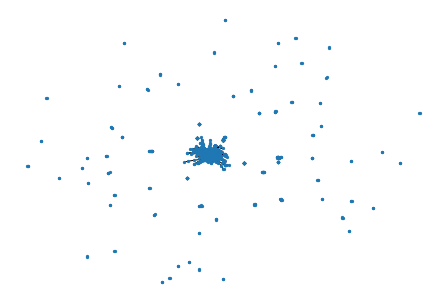

In [20]:
nx.draw(island, node_size = 5)

Next is a graph of the largest connected component of the subset.

We can see that the nodes are are really close and well-connected in the center.

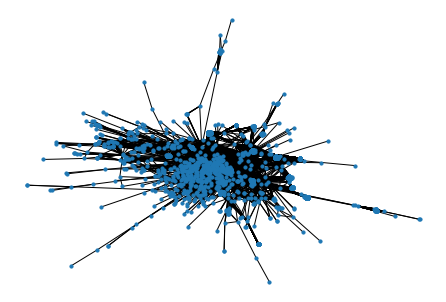

In [21]:
largest_cc = max(nx.connected_components(island), key=len)
lcc = island.subgraph(largest_cc).copy()
nx.draw(lcc, node_size = 10, width = 1)

The customers in the center are the most valuable customers for the company because the group is large and buys many of the same things.

***

### Analysis - Products

Now, we know which customers are more valuable...  But, what about the products? What are the products that these customers buy togerther frequently?

To analyze the network among the products, we project the graph on to the product nodes, with weight of the edges equal to the number of common customers purchasing the connected products.

In [13]:
P = bipartite.weighted_projected_graph(G, products)

The total number of products is:

In [23]:
P.number_of_nodes()

74258

The total number of connections is:

In [24]:
P.number_of_edges()

1712150

Next, let's check the length of the connected components:

In [25]:
pd.Series([len(c) for c in sorted(nx.connected_components(P), key=len)]).value_counts().sort_index()

1        20115
2         1266
3          386
4          154
5           65
6           41
7           34
8            4
9            5
10           5
11           1
12           1
48878        1
dtype: int64

Similar to the customer network, the product network has a large componet with 48878 nodes and other components with a few number of nodes. The result is showing that most of the products are related to each other. But how well are they related?

Again, we use the island method!

In [14]:
islands=island_method(P)

for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print('Threshold: ' + str(i[0]))
    print('Number of Nodes: ' + str(len(i[1])))
    print('Length of Connected Components')
    display(pd.DataFrame(pd.Series([len(c) for c in sorted(nx.connected_components(i[1]), key=len)]).value_counts().sort_index()).T)
    print()

Threshold: 1
Number of Nodes: 12617
Length of Connected Components


,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,23,110,6855
0,1051,460,156,94,58,33,16,11,7,2,3,1,4,2,1,1,1,1



Threshold: 122
Number of Nodes: 472
Length of Connected Components


,2,3,4,5,6,7,8,9,10,11,12,14,25
0,29,17,21,9,6,6,3,3,2,2,2,1,1



Threshold: 243
Number of Nodes: 162
Length of Connected Components


,2,3,4,5,6,7,8,9,11
0,15,6,12,2,2,1,1,2,1



Threshold: 364
Number of Nodes: 78
Length of Connected Components


,2,3,4,6,8,9
0,4,2,8,1,1,2



Threshold: 485
Number of Nodes: 25
Length of Connected Components


,2,4,9
0,4,2,1



Threshold: 606
Number of Nodes: 4
Length of Connected Components


,4
0,1


We would select the subset with threshold 122, which has 472 nodes. In this subset, the lengths of the components do not have extremely large difference. This is reasonable because you can have a million customers connected together by purchasing the same product, but you can not have a million products purchased by the same customer.

In [15]:
island = islands[1][1]

Create a summary of the nodes in the selected subset.

In [17]:
summarys = pd.DataFrame(dict(
    DEGREE = dict(island.degree(weight='weight')),
    DEGREE_CENTRALITY = nx.degree_centrality(island),
    EIGENVECTOR = nx.eigenvector_centrality(island, weight='weight'),
    CLOSENESS = nx.closeness_centrality(island),
    BETWEENNESS = nx.betweenness_centrality(island, weight='weight')
)) 
summarys = summarys.sort_values(by = 'DEGREE', ascending = False)
round(summarys,6)

,DEGREE,DEGREE_CENTRALITY,EIGENVECTOR,CLOSENESS,BETWEENNESS
B006HYLW32,4408,0.016985,0.333333,0.016985,0.0
B007M832YY,4408,0.016985,0.333333,0.016985,0.0
B0026KNQSA,4408,0.016985,0.333333,0.016985,0.0
B001RVFEP2,4408,0.016985,0.333333,0.016985,0.0
B000VK8AVK,4408,0.016985,0.333333,0.016985,0.0
...,...,...,...,...,...
B001LGGH40,136,0.002123,0.000000,0.002123,0.0
B001LGGH54,136,0.002123,0.000000,0.002123,0.0
B0051COPH6,129,0.002123,0.000000,0.010116,0.0
B00370CFR6,125,0.002123,0.000000,0.002123,0.0


In [29]:
round(summarys.mean(), 6)

DEGREE               1293.199153
DEGREE_CENTRALITY       0.012703
EIGENVECTOR             0.006367
CLOSENESS               0.012746
BETWEENNESS             0.000000
dtype: float64

The average degree is high. However, the closeness is low for the product network.

> This implies that these products are popular and bought frequently by some common customers. However, there are very few bundles of products that these customers bought frequently.

Let's confirm our findings with some figures.

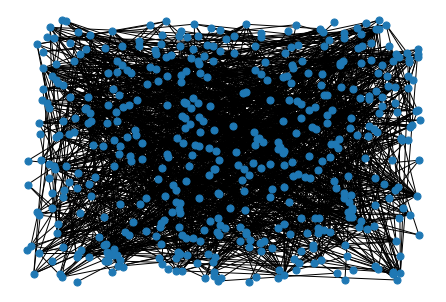

In [31]:
nx.draw_random(island, node_size = 50)

We have encountered a "hairball", but there is no closely-connected large subgraph.

We can examine graph of the most connected components:

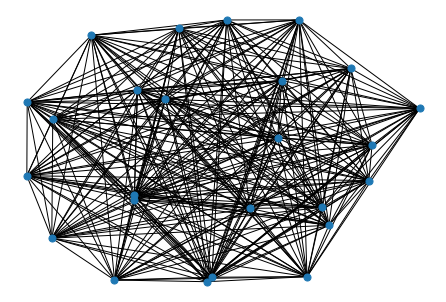

In [32]:
largest_cc = max(nx.connected_components(island), key=len)
lcc = island.subgraph(largest_cc).copy()
nx.draw(lcc, node_size = 50, width = 1)

We can see the nodes are well connected to each other, but they are not close.

Though these products are not close, we know that they are the most popular products bought by most customers. If we have limited inventory, these are the products we would like to keep.